# BM3DORNL Tutorial: Ring Artifact Removal for Neutron Imaging

This tutorial demonstrates how to use **bm3dornl** for removing ring artifacts from tomography sinograms. Ring artifacts are a common problem in neutron and X-ray imaging caused by detector pixel response variations.

## What You'll Learn

1. How to generate synthetic test data with realistic ring artifacts
2. Basic usage of the `bm3d_ring_artifact_removal` function
3. Understanding the difference between `generic` and `streak` modes
4. How to tune parameters for your data
5. Visualizing and evaluating results

## Prerequisites

```bash
pip install bm3dornl
```

This notebook is self-contained and uses synthetic phantom data, so no external files are required.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# BM3DORNL imports
from bm3dornl import bm3d_ring_artifact_removal
from bm3dornl.phantom import (
    shepp_logan_phantom,
    generate_sinogram,
    simulate_detector_gain_error,
    get_synthetic_noise,
)

# For reproducibility
np.random.seed(42)

print("Imports successful!")

Imports successful!


## 1. Generate Synthetic Test Data

We'll create a realistic test case using the Shepp-Logan phantom, which is a standard test image in tomography. The phantom module provides utilities to:

1. Generate a phantom image
2. Create a sinogram via Radon transform
3. Add detector gain errors (which cause ring artifacts)
4. Add synthetic noise (both white noise and streak noise)

In [2]:
# Step 1: Generate Shepp-Logan phantom
phantom_size = 256
phantom = shepp_logan_phantom(size=phantom_size, contrast_factor=2.0)

# Step 2: Generate sinogram via Radon transform
scan_step = 0.5  # degrees between projections
clean_sinogram, angles = generate_sinogram(phantom, scan_step=scan_step)

print(f"Phantom shape: {phantom.shape}")
print(f"Sinogram shape: {clean_sinogram.shape} (projections x detector pixels)")
print(f"Number of projection angles: {len(angles)}")

Phantom shape: (256, 256)
Sinogram shape: (720, 363) (projections x detector pixels)
Number of projection angles: 720


In [3]:
# Step 3: Add detector gain error (causes ring artifacts)
# The gain range simulates pixel-to-pixel sensitivity variations
noisy_sinogram, detector_gain = simulate_detector_gain_error(
    clean_sinogram,
    detector_gain_range=(0.95, 1.05),  # 5% gain variation
    detector_gain_error=0.02,  # 2% temporal variation
)

# Step 4: Add synthetic noise (white + streak noise)
synthetic_noise = get_synthetic_noise(
    image_size=noisy_sinogram.shape,
    streak_kernel_width=1,
    streak_kernel_length=100,
    white_noise_intensity=0.02,
    streak_noise_intensity=0.03,
)

# Combine noise with sinogram
noisy_sinogram = noisy_sinogram + synthetic_noise.astype(np.float32)

# Normalize to [0, 1] range
noisy_sinogram = (noisy_sinogram - noisy_sinogram.min()) / (
    noisy_sinogram.max() - noisy_sinogram.min()
)
noisy_sinogram = noisy_sinogram.astype(np.float32)

print(f"Noisy sinogram range: [{noisy_sinogram.min():.3f}, {noisy_sinogram.max():.3f}]")

Noisy sinogram range: [0.000, 1.000]


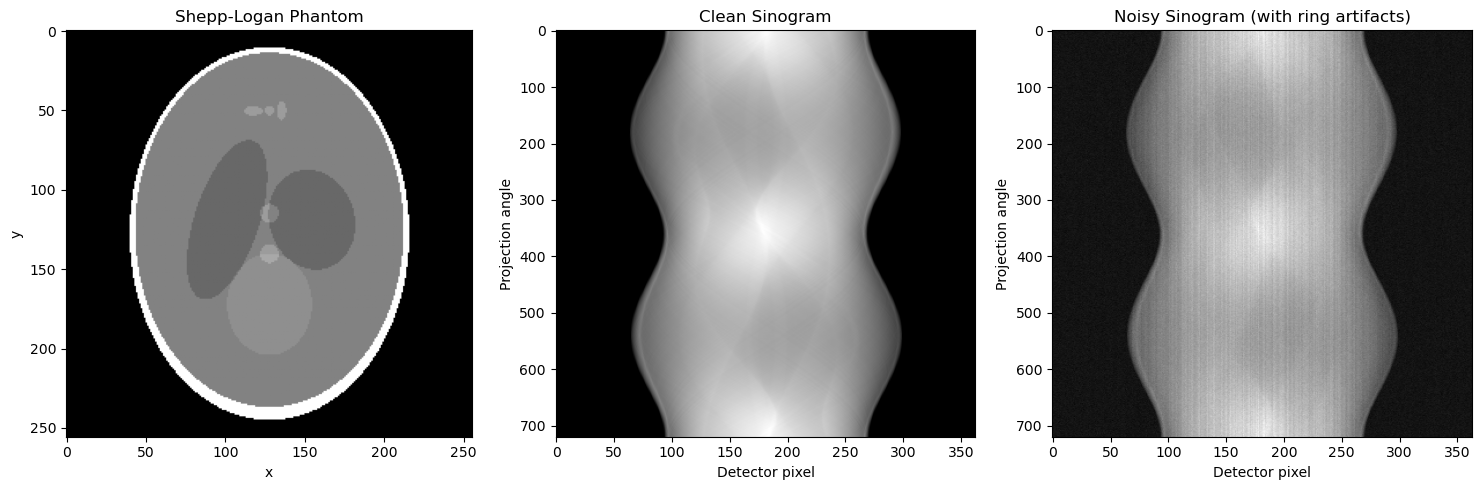

In [4]:
# Visualize the phantom and sinograms
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(phantom, cmap="gray")
axes[0].set_title("Shepp-Logan Phantom")
axes[0].set_xlabel("x")
axes[0].set_ylabel("y")

axes[1].imshow(clean_sinogram, cmap="gray", aspect="auto")
axes[1].set_title("Clean Sinogram")
axes[1].set_xlabel("Detector pixel")
axes[1].set_ylabel("Projection angle")

im = axes[2].imshow(noisy_sinogram, cmap="gray", aspect="auto")
axes[2].set_title("Noisy Sinogram (with ring artifacts)")
axes[2].set_xlabel("Detector pixel")
axes[2].set_ylabel("Projection angle")

plt.tight_layout()
plt.show()

# Note the vertical streaks in the noisy sinogram - these cause ring artifacts in reconstruction

## 2. Basic Usage: Ring Artifact Removal

The main function is `bm3d_ring_artifact_removal`. It has two modes:

- **`generic`**: Standard BM3D denoising for white (random) noise
- **`streak`**: Specialized mode for ring artifacts (vertical streaks in sinograms)

For ring artifact removal, always use `mode="streak"`.

In [5]:
import time

# Apply BM3D with streak mode (recommended for ring artifacts)
t0 = time.time()
denoised_streak = bm3d_ring_artifact_removal(
    noisy_sinogram,
    mode="streak",
    sigma_random=0.05,  # Estimated noise level (adjust based on your data)
)
t1 = time.time()

print(f"Processing time: {t1 - t0:.2f} seconds")
print(f"Output shape: {denoised_streak.shape}")
print(f"Output range: [{denoised_streak.min():.3f}, {denoised_streak.max():.3f}]")

Processing time: 0.14 seconds
Output shape: (720, 363)
Output range: [0.017, 0.913]


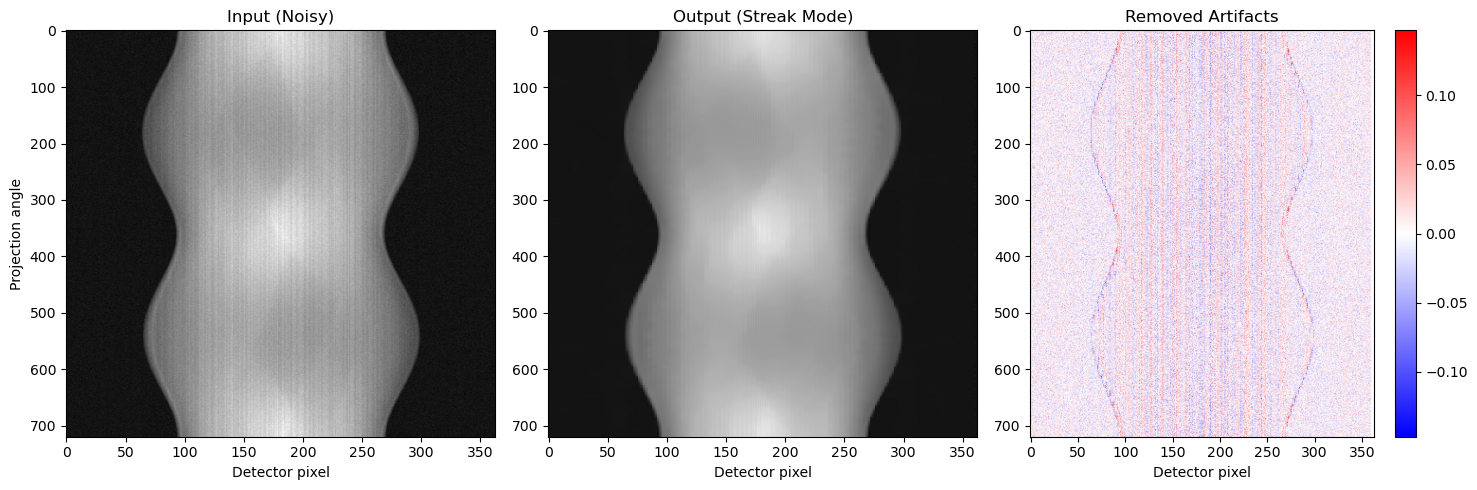

In [6]:
# Compare input vs output
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

vmin, vmax = noisy_sinogram.min(), noisy_sinogram.max()

axes[0].imshow(noisy_sinogram, cmap="gray", aspect="auto", vmin=vmin, vmax=vmax)
axes[0].set_title("Input (Noisy)")
axes[0].set_xlabel("Detector pixel")
axes[0].set_ylabel("Projection angle")

axes[1].imshow(denoised_streak, cmap="gray", aspect="auto", vmin=vmin, vmax=vmax)
axes[1].set_title("Output (Streak Mode)")
axes[1].set_xlabel("Detector pixel")

# Show what was removed (difference image)
diff = noisy_sinogram - denoised_streak
diff_max = np.abs(diff).max() * 0.8
im = axes[2].imshow(diff, cmap="bwr", aspect="auto", vmin=-diff_max, vmax=diff_max)
axes[2].set_title("Removed Artifacts")
axes[2].set_xlabel("Detector pixel")
plt.colorbar(im, ax=axes[2])

plt.tight_layout()
plt.show()

## 3. Comparing Generic vs Streak Mode

The `streak` mode is specifically designed for vertical artifacts. Let's compare it with `generic` mode to see the difference.

Generic mode time: 0.14 seconds


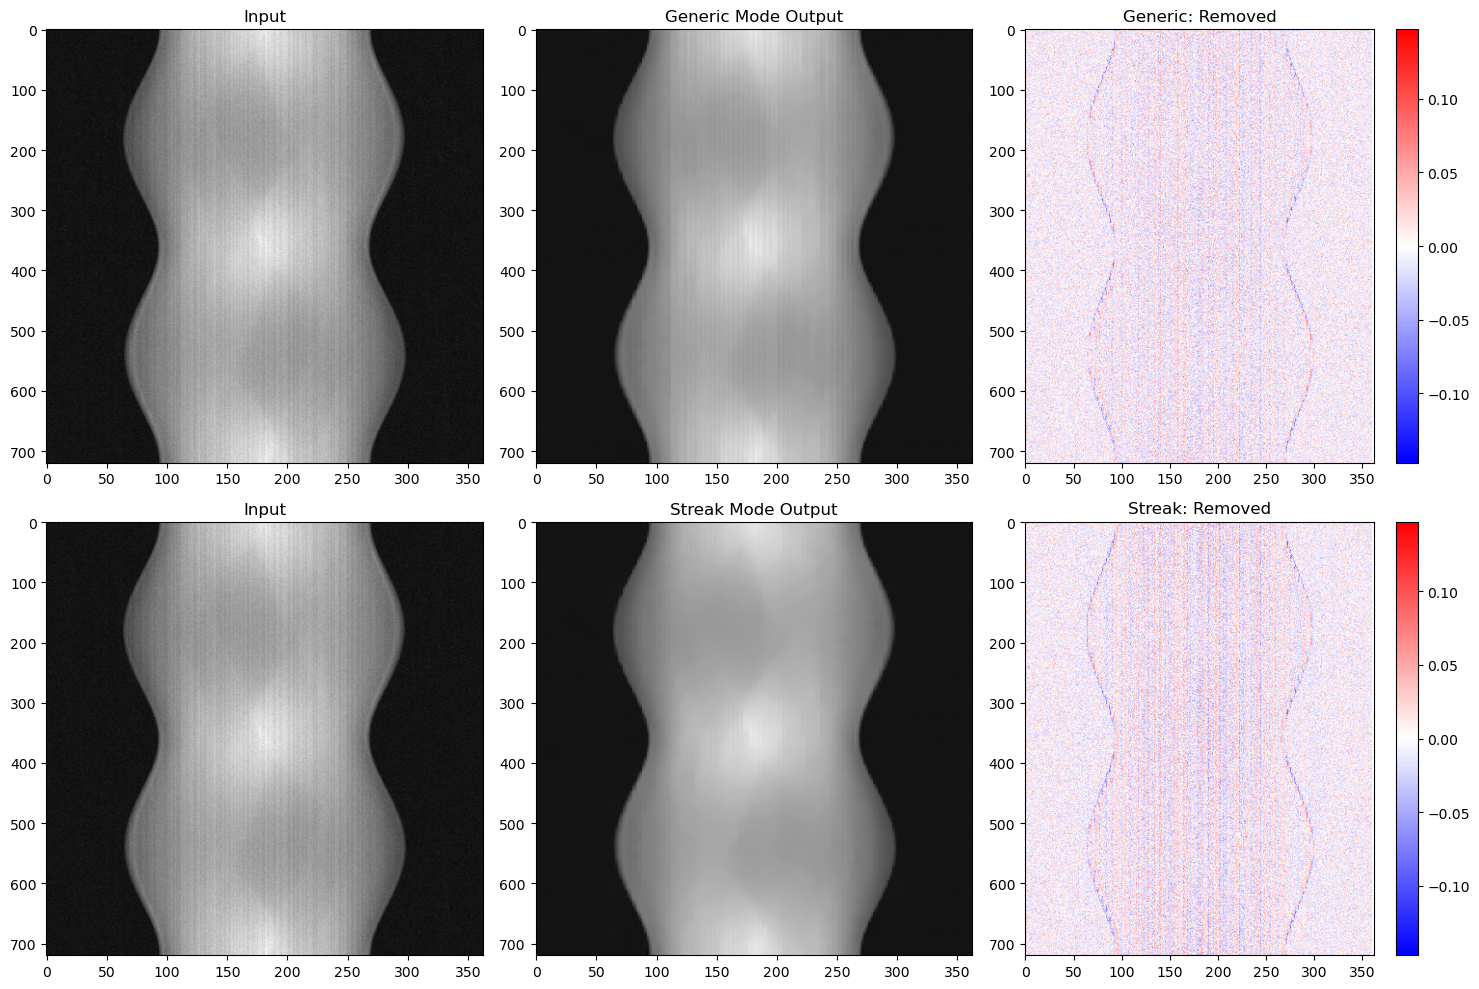


Notice how streak mode better targets the vertical artifacts!


In [7]:
# Apply generic mode for comparison
t0 = time.time()
denoised_generic = bm3d_ring_artifact_removal(
    noisy_sinogram,
    mode="generic",
    sigma_random=0.05,
)
t1 = time.time()
print(f"Generic mode time: {t1 - t0:.2f} seconds")

# Compare both modes
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Row 1: Generic mode
axes[0, 0].imshow(noisy_sinogram, cmap="gray", aspect="auto", vmin=vmin, vmax=vmax)
axes[0, 0].set_title("Input")
axes[0, 1].imshow(denoised_generic, cmap="gray", aspect="auto", vmin=vmin, vmax=vmax)
axes[0, 1].set_title("Generic Mode Output")
diff_generic = noisy_sinogram - denoised_generic
im0 = axes[0, 2].imshow(
    diff_generic, cmap="bwr", aspect="auto", vmin=-diff_max, vmax=diff_max
)
axes[0, 2].set_title("Generic: Removed")
plt.colorbar(im0, ax=axes[0, 2])

# Row 2: Streak mode
axes[1, 0].imshow(noisy_sinogram, cmap="gray", aspect="auto", vmin=vmin, vmax=vmax)
axes[1, 0].set_title("Input")
axes[1, 1].imshow(denoised_streak, cmap="gray", aspect="auto", vmin=vmin, vmax=vmax)
axes[1, 1].set_title("Streak Mode Output")
diff_streak = noisy_sinogram - denoised_streak
im1 = axes[1, 2].imshow(
    diff_streak, cmap="bwr", aspect="auto", vmin=-diff_max, vmax=diff_max
)
axes[1, 2].set_title("Streak: Removed")
plt.colorbar(im1, ax=axes[1, 2])

plt.tight_layout()
plt.show()

print("\nNotice how streak mode better targets the vertical artifacts!")

## 4. Parameter Tuning

Key parameters to adjust for your data:

| Parameter | Default | Description |
|-----------|---------|-------------|
| `sigma_random` | 0.1 | Noise level estimate. Higher = more aggressive denoising |
| `patch_size` | 8 | Size of patches for block matching (7 or 8 recommended) |
| `step_size` | 4 | Stride for patch extraction. Lower = better quality but slower |
| `search_window` | 24 | Search range for similar patches |
| `max_matches` | 16 | Maximum similar patches per group |

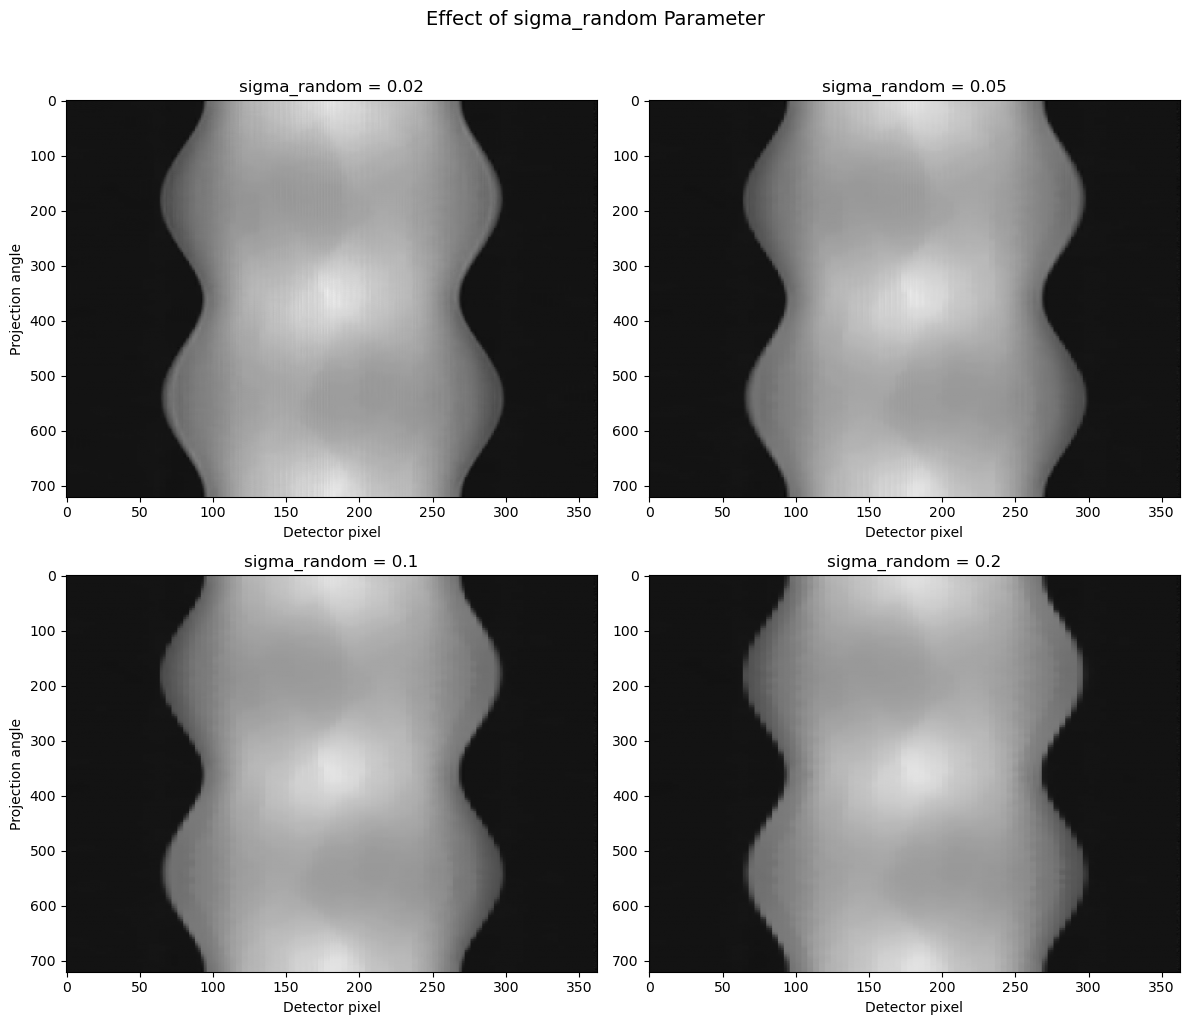

Higher sigma_random = more aggressive denoising (may over-smooth)
Lower sigma_random = preserves more detail (may leave artifacts)


In [8]:
# Demonstrate effect of sigma_random parameter
sigma_values = [0.02, 0.05, 0.10, 0.20]

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for i, sigma in enumerate(sigma_values):
    result = bm3d_ring_artifact_removal(
        noisy_sinogram,
        mode="streak",
        sigma_random=sigma,
    )
    axes[i].imshow(result, cmap="gray", aspect="auto", vmin=vmin, vmax=vmax)
    axes[i].set_title(f"sigma_random = {sigma}")
    axes[i].set_xlabel("Detector pixel")
    if i % 2 == 0:
        axes[i].set_ylabel("Projection angle")

plt.suptitle("Effect of sigma_random Parameter", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

print("Higher sigma_random = more aggressive denoising (may over-smooth)")
print("Lower sigma_random = preserves more detail (may leave artifacts)")

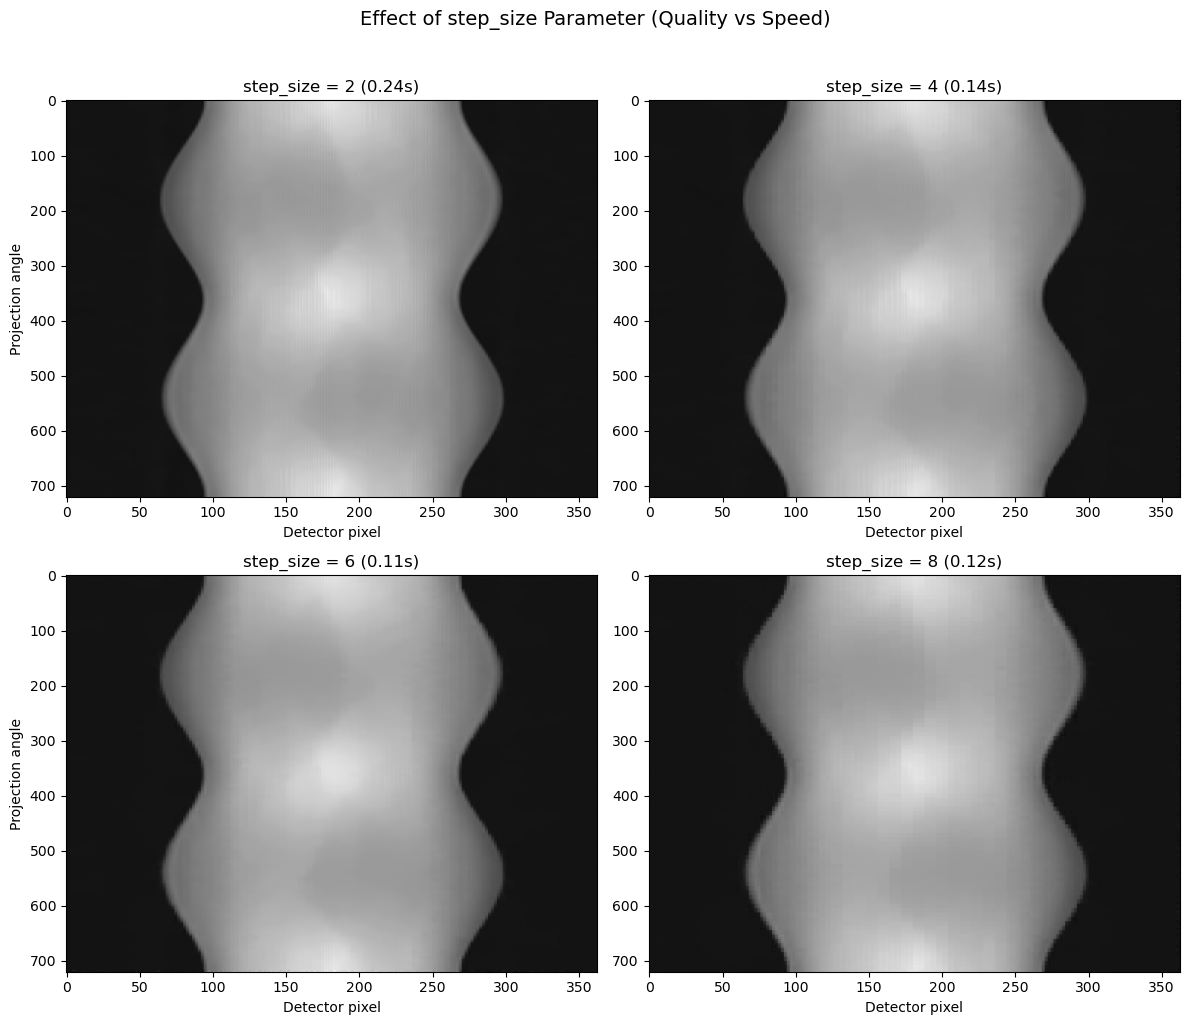


Smaller step_size = higher quality but slower
Larger step_size = faster but may miss some artifacts


In [9]:
# Demonstrate effect of step_size parameter (quality vs speed tradeoff)
step_sizes = [2, 4, 6, 8]

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

times = []
for i, step in enumerate(step_sizes):
    t0 = time.time()
    result = bm3d_ring_artifact_removal(
        noisy_sinogram,
        mode="streak",
        sigma_random=0.05,
        step_size=step,
    )
    elapsed = time.time() - t0
    times.append(elapsed)

    axes[i].imshow(result, cmap="gray", aspect="auto", vmin=vmin, vmax=vmax)
    axes[i].set_title(f"step_size = {step} ({elapsed:.2f}s)")
    axes[i].set_xlabel("Detector pixel")
    if i % 2 == 0:
        axes[i].set_ylabel("Projection angle")

plt.suptitle("Effect of step_size Parameter (Quality vs Speed)", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

print("\nSmaller step_size = higher quality but slower")
print("Larger step_size = faster but may miss some artifacts")

## 5. Evaluating Results with Histograms

Histograms help assess denoising quality. Good denoising should:
- Reduce the spread (variance) of pixel values
- Preserve the overall distribution shape
- Not introduce artificial peaks or valleys

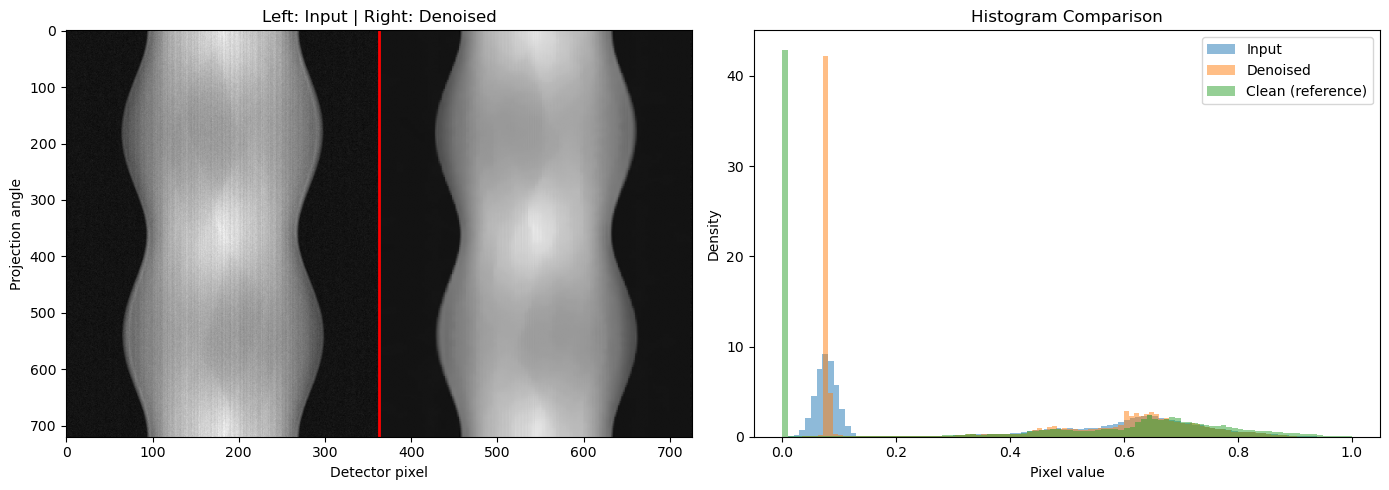

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Image comparison
axes[0].imshow(
    np.hstack([noisy_sinogram, denoised_streak]),
    cmap="gray",
    aspect="auto",
    vmin=vmin,
    vmax=vmax,
)
axes[0].axvline(x=noisy_sinogram.shape[1], color="red", linewidth=2)
axes[0].set_title("Left: Input | Right: Denoised")
axes[0].set_xlabel("Detector pixel")
axes[0].set_ylabel("Projection angle")

# Histogram comparison
axes[1].hist(noisy_sinogram.flatten(), bins=100, alpha=0.5, label="Input", density=True)
axes[1].hist(
    denoised_streak.flatten(), bins=100, alpha=0.5, label="Denoised", density=True
)
axes[1].hist(
    clean_sinogram.flatten(),
    bins=100,
    alpha=0.5,
    label="Clean (reference)",
    density=True,
)
axes[1].set_xlabel("Pixel value")
axes[1].set_ylabel("Density")
axes[1].set_title("Histogram Comparison")
axes[1].legend()

plt.tight_layout()
plt.show()

## 6. Processing 3D Stacks

For real tomography data, you often have a 3D stack of sinograms (one per detector row). BM3DORNL handles 3D stacks automatically with batch processing for memory efficiency.

In [11]:
# Create a small 3D stack (5 slices) for demonstration
n_slices = 5
stack_3d = np.stack([noisy_sinogram] * n_slices, axis=0)

# Add some variation between slices
for i in range(n_slices):
    noise = np.random.normal(0, 0.01, stack_3d[i].shape).astype(np.float32)
    stack_3d[i] = np.clip(stack_3d[i] + noise, 0, 1)

print(f"Stack shape: {stack_3d.shape} (slices, projections, detector pixels)")

# Process the entire stack
t0 = time.time()
denoised_stack = bm3d_ring_artifact_removal(
    stack_3d,
    mode="streak",
    sigma_random=0.05,
    batch_size=2,  # Process 2 slices at a time (memory control)
)
t1 = time.time()

print(f"Stack processing time: {t1 - t0:.2f} seconds")
print(f"Output shape: {denoised_stack.shape}")

Stack shape: (5, 720, 363) (slices, projections, detector pixels)
Stack processing time: 0.45 seconds
Output shape: (5, 720, 363)


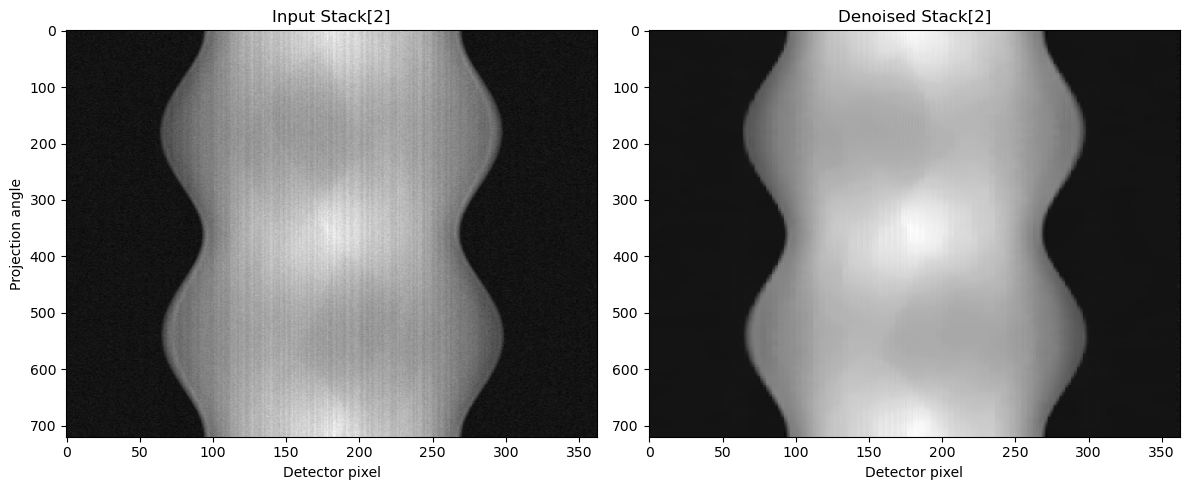

In [12]:
# Visualize one slice from the stack
slice_idx = 2

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].imshow(stack_3d[slice_idx], cmap="gray", aspect="auto")
axes[0].set_title(f"Input Stack[{slice_idx}]")
axes[0].set_xlabel("Detector pixel")
axes[0].set_ylabel("Projection angle")

axes[1].imshow(denoised_stack[slice_idx], cmap="gray", aspect="auto")
axes[1].set_title(f"Denoised Stack[{slice_idx}]")
axes[1].set_xlabel("Detector pixel")

plt.tight_layout()
plt.show()

## 7. Summary and Best Practices

### Quick Start Recipe

```python
from bm3dornl import bm3d_ring_artifact_removal

# For ring artifact removal, always use streak mode
denoised = bm3d_ring_artifact_removal(
    sinogram,
    mode="streak",
    sigma_random=0.05,  # Adjust based on noise level
)
```

### Parameter Guidelines

| Scenario | Recommended Settings |
|----------|---------------------|
| Light artifacts | `sigma_random=0.02-0.05` |
| Moderate artifacts | `sigma_random=0.05-0.10` |
| Heavy artifacts | `sigma_random=0.10-0.20` |
| Faster processing | `step_size=6-8`, `max_matches=8` |
| Higher quality | `step_size=2-3`, `max_matches=32` |
| Large stacks | Reduce `batch_size` if memory limited |

### Tips

1. **Start with defaults** - The default parameters work well for most cases
2. **Estimate sigma_random** - This is the most important parameter. Start low and increase if artifacts remain
3. **Use streak mode** - For ring artifacts, `mode="streak"` significantly outperforms `mode="generic"`
4. **Check the difference image** - Visualize `input - output` to ensure you're removing artifacts, not signal
5. **Normalize your data** - Best results when input is in [0, 1] range

In [13]:
print("Tutorial complete!")
print("\nFor more information:")
print("  - Documentation: https://bm3dornl.readthedocs.io/")
print("  - GitHub: https://github.com/ornlneutronimaging/bm3dornl")
print("  - GUI Application: pip install bm3dornl[gui]")

Tutorial complete!

For more information:
  - Documentation: https://bm3dornl.readthedocs.io/
  - GitHub: https://github.com/ornlneutronimaging/bm3dornl
  - GUI Application: pip install bm3dornl[gui]
